In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import os
os.chdir("/Users/pavelfilippov/Downloads/Heart_Failure_Prediction/")

<h2>Вопросы для исследования:</h2>
1. Есть ли у пациентов с диабетом более высокая вероятность развития сердечных заболеваний в раннем возрасте?<br/> 
2. Есть ли определенная демографическа группа, которая подвержена более высокому риску сердечных заболеваний?  <br/> 
3. Есть ли большая вероятность сердечно-сосудистых заболеваний у курящих людей, чем у некурящих?  <br/> 
4. Снижают ли физические упражнения риск развития сердечных заболеваний?  

In [39]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [41]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


<h2>Does age and sex serve as predictive markers for mortality within the context of heart diseases?</h2>

Text(0, 0.5, 'Death count')

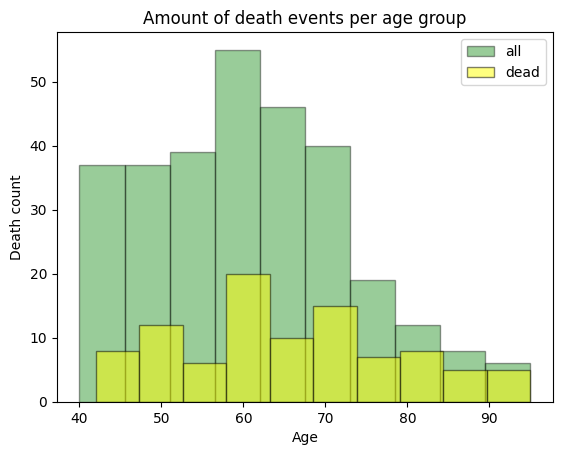

In [42]:
plt.hist(data['age'], color='green', edgecolor = 'black',bins = int(100/10), label='all', alpha=0.4)
plt.hist(data[data['DEATH_EVENT'] == 1]['age'], color = 'yellow', edgecolor = 'black', bins = int(100/10), label='dead',
         alpha=0.5)
plt.legend()
plt.title('Amount of death events per age group')
plt.xlabel('Age')
plt.ylabel('Death count')

The likelihood of death increases notably around the age of 60 compared to other age groups. Additionally, age appears to be a significant factor in mortality, as nearly all individuals over 85 have deceased.

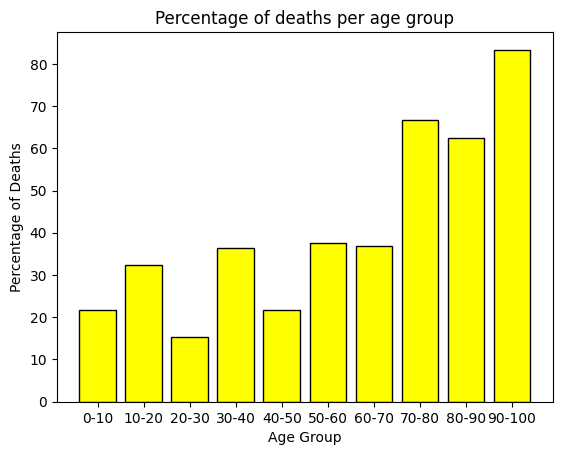

In [43]:
# Подсчет общего числа людей и числа смертей в каждой возрастной группе
age_bins = int(100/10)
total_count, _ = np.histogram(data['age'], bins=age_bins)
death_count, _ = np.histogram(data[data['DEATH_EVENT'] == 1]['age'], bins=age_bins)

# Вычисление процентного соотношения смертей к общему числу людей в каждой возрастной группе
percentage_death = (death_count / total_count) * 100

# Построение графика
plt.bar(range(len(percentage_death)), percentage_death, color='yellow', edgecolor='black')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Deaths')
plt.title('Percentage of deaths per age group')
plt.xticks(range(len(percentage_death)), [f'{i*10}-{(i+1)*10}' for i in range(len(percentage_death))])
plt.show()

Text(0, 0.5, 'Death count')

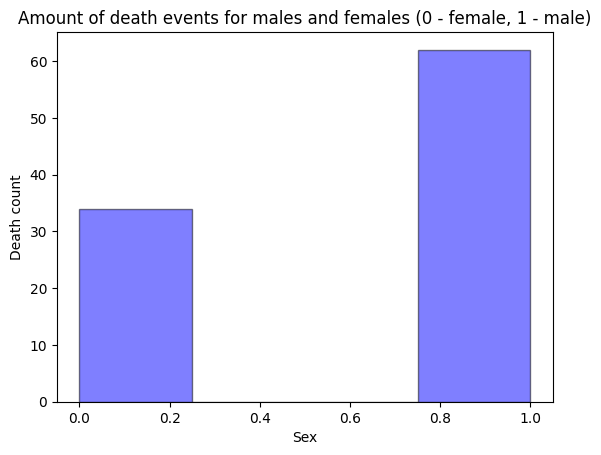

In [44]:
plt.hist(data[data['DEATH_EVENT'] == 1]['sex'], color = 'blue', edgecolor = 'black',
         bins = int(4), alpha=0.5)
plt.title('Amount of death events for males and females (0 - female, 1 - male)')
plt.xlabel('Sex')
plt.ylabel('Death count')

Text(0.5, 1.0, 'Pie chart of death and sex info')

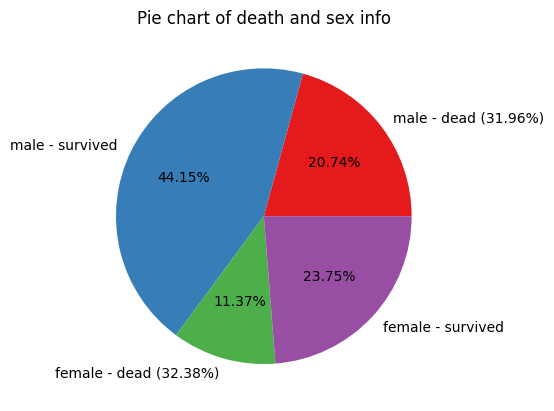

In [45]:
male = data[data['sex'] == 1]
female = data[data['sex'] == 0]

male_dead = len(male[male['DEATH_EVENT'] == 1])
male_survived = len(male[male['DEATH_EVENT'] == 0])
female_dead = len(female[female['DEATH_EVENT'] == 1])
female_survived = len(female[female['DEATH_EVENT'] == 0])

total_male = male_dead + male_survived
total_female = female_dead + female_survived

# Рассчитываем процент умерших среди мужчин и женщин
male_death_percentage = (male_dead / total_male) * 100
female_death_percentage = (female_dead / total_female) * 100

pie_info = [male_dead, male_survived, female_dead, female_survived]
labels = [f'male - dead ({male_death_percentage:.2f}%)', f'male - survived', f'female - dead ({female_death_percentage:.2f}%)', 'female - survived']

fig, ax = plt.subplots()
ax.pie(pie_info, labels=labels, autopct='%1.2f%%', colors=sns.color_palette('Set1'))
ax.set_title('Pie chart of death and sex info')

The observation that more men get sick and die while the percentage of deaths in women and men is almost equal suggests a flaw in the evaluation criterion.

<h2>Let's visualize the data correlation using a Seaborn heatmap</h2>

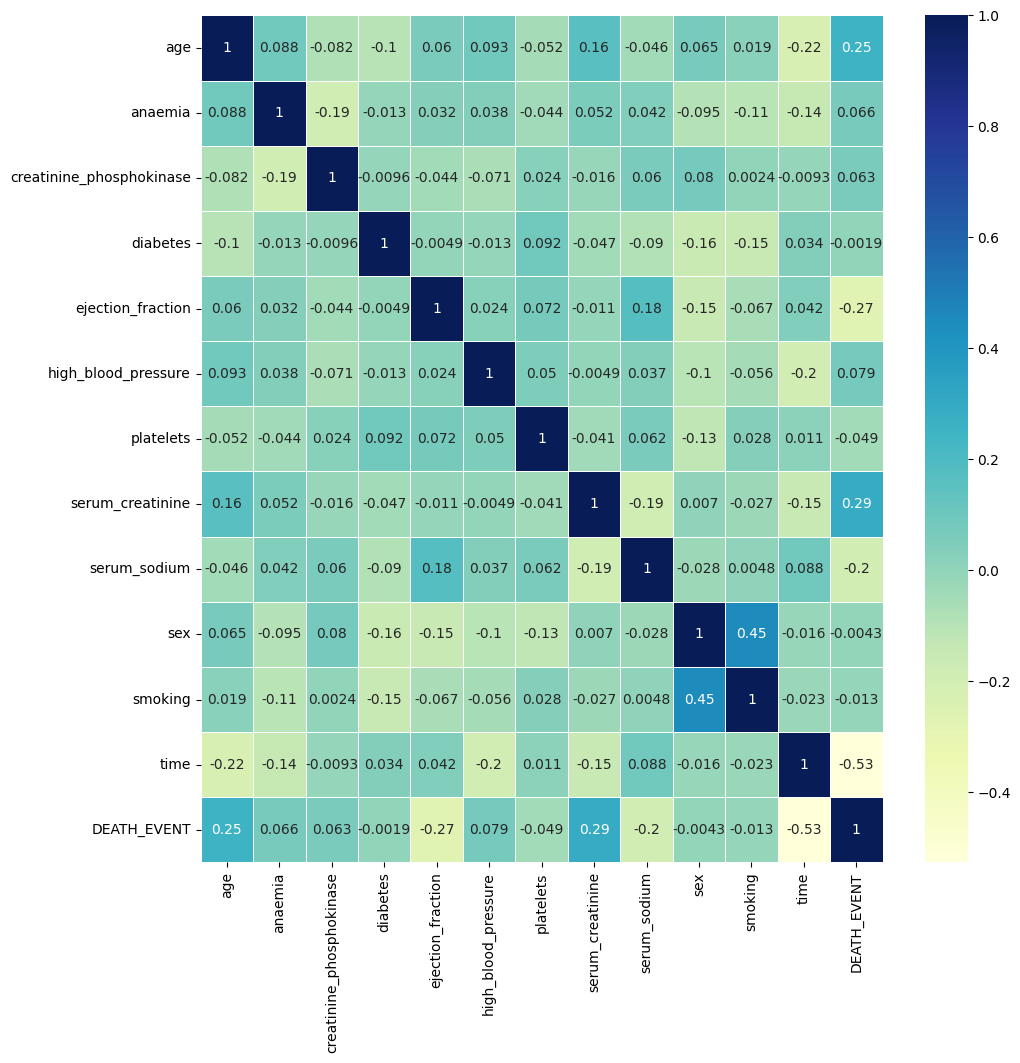

In [46]:
fig, ax = plt.subplots(figsize=(11,11))        
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, linewidths=.5, ax=ax)
plt.show()

We aim to explore correlations between DEATH_EVENT, anaemia, high blood pressure, and various factors. Initially, we'll analyze the correlation between death and serum creatinine levels.

The typical range for serum creatinine is:
1. For adult men: 0.74 to 1.35 mg/dL (65.4 to 119.3 micromoles/L)
2. For adult women: 0.59 to 1.04 mg/dL (52.2 to 91.9 micromoles/L).

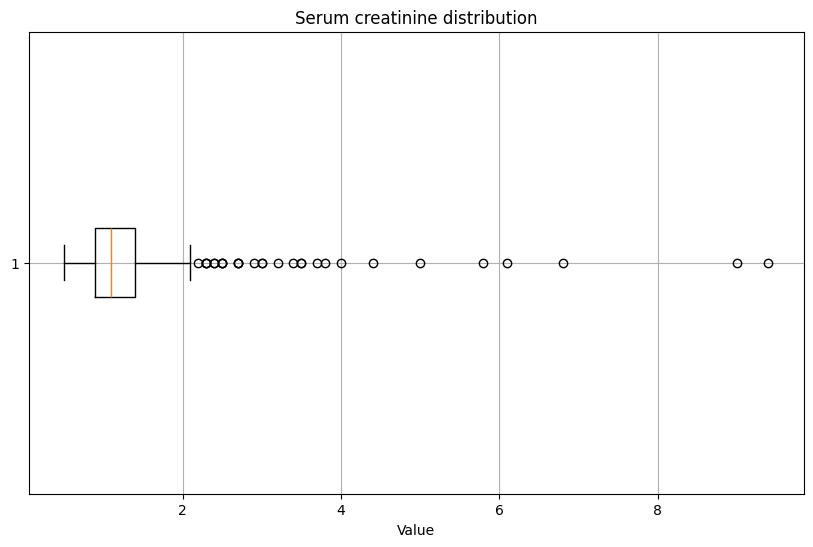

In [47]:
plt.figure(figsize=(10,6))
plt.boxplot(data['serum_creatinine'], vert=False)
plt.xlabel('Value')
plt.title("Serum creatinine distribution")
plt.grid()

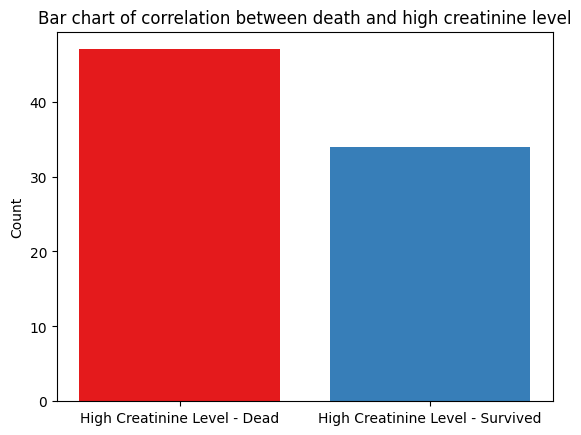

In [48]:
outliers = data[data['serum_creatinine'] > 1.35]
normal = data[data['serum_creatinine'] <= 1.35]

death_outliers = len(outliers[outliers['DEATH_EVENT'] == 1])
survived_outliers = len(outliers[outliers['DEATH_EVENT'] == 0])

labels = ['High Creatinine Level - Dead', 'High Creatinine Level - Survived']

plt.bar(labels, [death_outliers, survived_outliers], color=sns.color_palette('Set1'))
plt.title('Bar chart of correlation between death and high creatinine level')
plt.ylabel('Count')
plt.show()

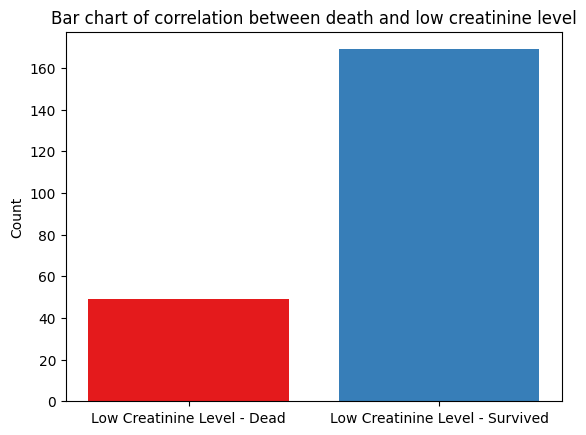

In [49]:
info = [len(normal[normal['DEATH_EVENT'] == 1]), len(normal[normal['DEATH_EVENT'] == 0])]
labels = ['Low Creatinine Level - Dead', 'Low Creatinine Level - Survived']

plt.bar(labels, info, color=sns.color_palette('Set1'))
plt.title('Bar chart of correlation between death and low creatinine level')
plt.ylabel('Count')
plt.show()

Observations indicate a higher likelihood of mortality among individuals with elevated creatinine levels.

<h2>Is there an increased propensity for the development of heart disease at an earlier age among patients with diabetes?</h2>

Text(0, 0.5, 'Diabetes')

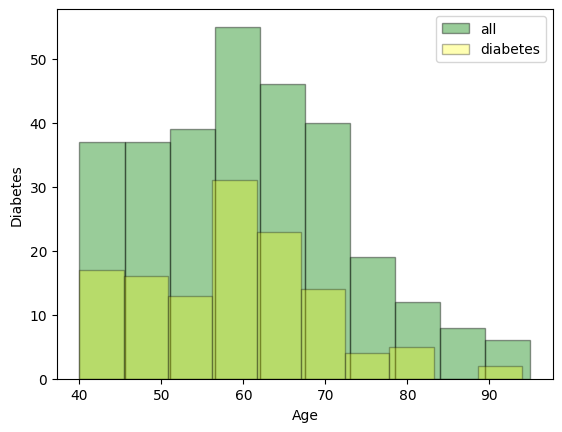

In [50]:
plt.hist(data['age'], color='green', edgecolor = 'black',bins = int(100/10), label='all', alpha=0.4)
plt.hist(data[data['diabetes'] == 1]['age'], color = 'yellow', edgecolor = 'black', bins = int(100/10), label='diabetes', alpha=0.3)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Diabetes')

In [51]:
diabetes = data[data['diabetes'] == 1]
no_diabetes = data[data['diabetes'] == 0]

print('Average age of death in people with diabetes: ', diabetes[diabetes['DEATH_EVENT'] == 1]['age'].mean())
print('Average age of death in people without diabetes: ', no_diabetes[no_diabetes['DEATH_EVENT'] == 1]['age'].mean())

Average age of death in people with diabetes:  62.891675
Average age of death in people without diabetes:  66.875


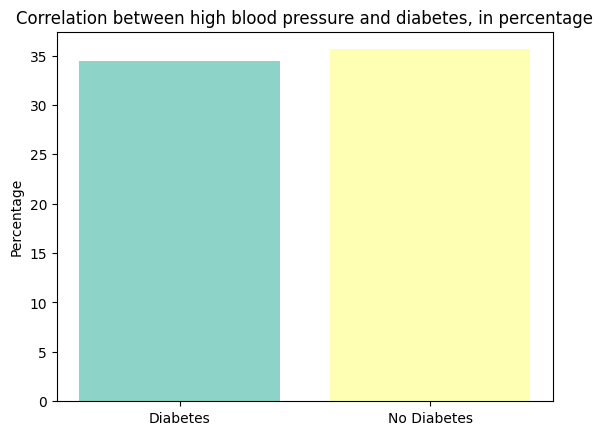

In [52]:
x = ['Diabetes', 'No Diabetes']
y = [
    len(diabetes[diabetes['high_blood_pressure'] == 1]) / len(diabetes) * 100,
    len(no_diabetes[no_diabetes['high_blood_pressure'] == 1]) / len(no_diabetes) * 100
]

plt.bar(x, y, color=sns.color_palette('Set3'))
plt.title('Correlation between high blood pressure and diabetes, in percentage')
plt.ylabel('Percentage')
plt.show()

Observations suggest a lack of correlation between diabetes and high blood pressure, as the data for both groups are nearly identical.

<h2>We aim to explore whether there exists a correlation between smoking and disease occurrence.</h2>

In [53]:
smokers = data[data['smoking'] == 1]
non_smokers = data[data['smoking'] == 0]

print(' Smokers: ', len(smokers), 'people.')
print(' Non-smokers: ', len(non_smokers), 'people.')

 Smokers:  96 people.
 Non-smokers:  203 people.


Text(0, 0.5, 'Amount')

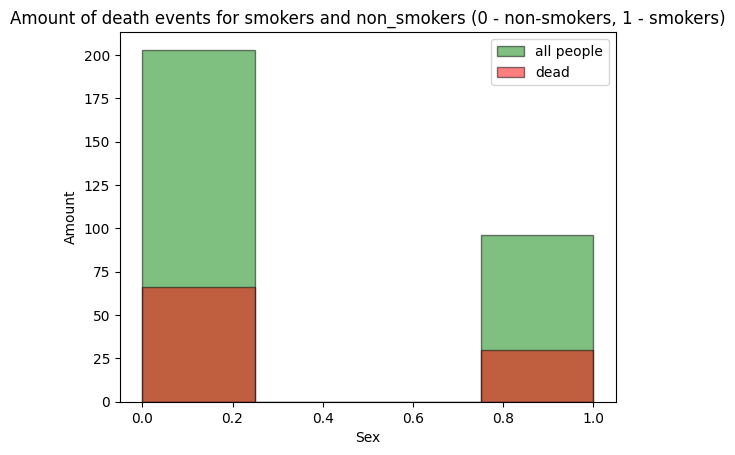

In [54]:
plt.hist(data['smoking'], color = 'green', edgecolor = 'black',
         bins = int(4), alpha=0.5, label='all people')
plt.hist(data[data['DEATH_EVENT'] == 1]['smoking'], color = 'red', edgecolor = 'black',
         bins = int(4), alpha=0.5, label='dead')
plt.legend()
plt.title('Amount of death events for smokers and non_smokers (0 - non-smokers, 1 - smokers)')
plt.xlabel('Sex')
plt.ylabel('Amount')

The dataset reveals a higher mortality rate among non-smokers compared to smokers. However, this observation is likely influenced by inherent limitations within the dataset, such as its small sample size and an overrepresentation of smokers. Therefore, the reliability and generalizability of the findings may be compromised.

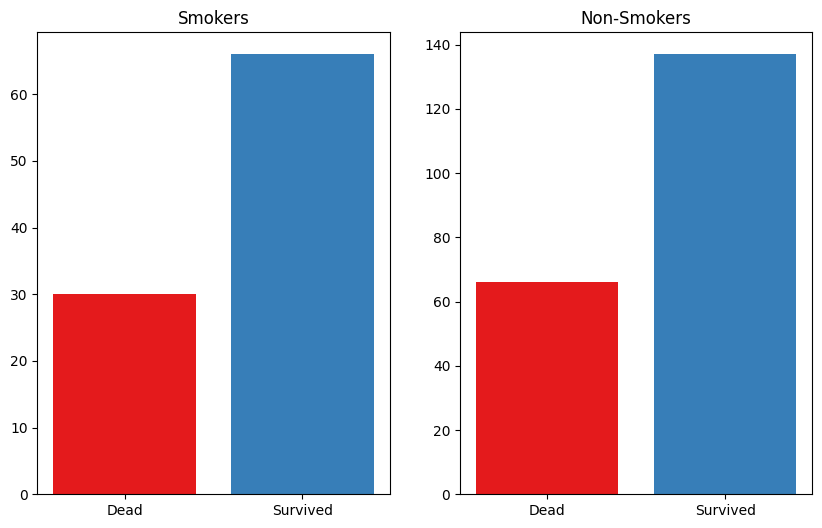

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# For smokers
death_smokers = len(smokers[smokers['DEATH_EVENT'] == 1])
survived_smokers = len(smokers[smokers['DEATH_EVENT'] == 0])
axs[0].bar(['Dead', 'Survived'], [death_smokers, survived_smokers], color=sns.color_palette('Set1'))
axs[0].set_title('Smokers')

# For non-smokers
death_non_smokers = len(non_smokers[non_smokers['DEATH_EVENT'] == 1])
survived_non_smokers = len(non_smokers[non_smokers['DEATH_EVENT'] == 0])
axs[1].bar(['Dead', 'Survived'], [death_non_smokers, survived_non_smokers], color=sns.color_palette('Set1'))
axs[1].set_title('Non-Smokers')

plt.show()


In terms of proportion, there appears to be no correlation between smoking and the incidence of heart failure.

<h2>Now, let's construct a classification model.</h2>

In [56]:
y = data['DEATH_EVENT']
x = data.drop(['DEATH_EVENT'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [57]:
rf = RandomForestClassifier(verbose=True)
rf_params = {"max_depth": range(3,19,3),
             "max_features": range(3,12,2),
             "n_estimators": [10, 500, 1000],
             "min_samples_split": [2, 5, 10]}
grid = GridSearchCV(rf, rf_params, cv = 10, n_jobs = -1, verbose=True)
grid.fit(x_train, y_train)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

GridSearchCV(cv=10, estimator=RandomForestClassifier(verbose=True), n_jobs=-1,
             param_grid={'max_depth': range(3, 19, 3),
                         'max_features': range(3, 12, 2),
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             verbose=True)

In [58]:
grid.best_params_


{'max_depth': 9,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

In [59]:
rf_params = {"max_depth": range(5,8,1),
             "max_features": range(6,9,1),
             "n_estimators": range(2,500, 50),
             "min_samples_split": [10, 20, 30, 40, 50]}


In [60]:
grid = GridSearchCV(rf, rf_params, cv = 10, n_jobs = -1)
grid.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

GridSearchCV(cv=10, estimator=RandomForestClassifier(verbose=True), n_jobs=-1,
             param_grid={'max_depth': range(5, 8), 'max_features': range(6, 9),
                         'min_samples_split': [10, 20, 30, 40, 50],
                         'n_estimators': range(2, 500, 50)})

In [61]:
grid.best_params_


{'max_depth': 5,
 'max_features': 6,
 'min_samples_split': 20,
 'n_estimators': 352}

In [62]:
rf = RandomForestClassifier(max_depth=6,
 max_features=6,
 min_samples_split=20,
 n_estimators=152)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=6, max_features=6, min_samples_split=20,
                       n_estimators=152)

In [63]:
y_pred = rf.predict(x_test)
print(f'model accuracy: {accuracy_score(y_pred, y_test)*100}%')

model accuracy: 83.33333333333334%


In [64]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.95      0.88        37
           1       0.88      0.65      0.75        23

    accuracy                           0.83        60
   macro avg       0.85      0.80      0.81        60
weighted avg       0.84      0.83      0.83        60



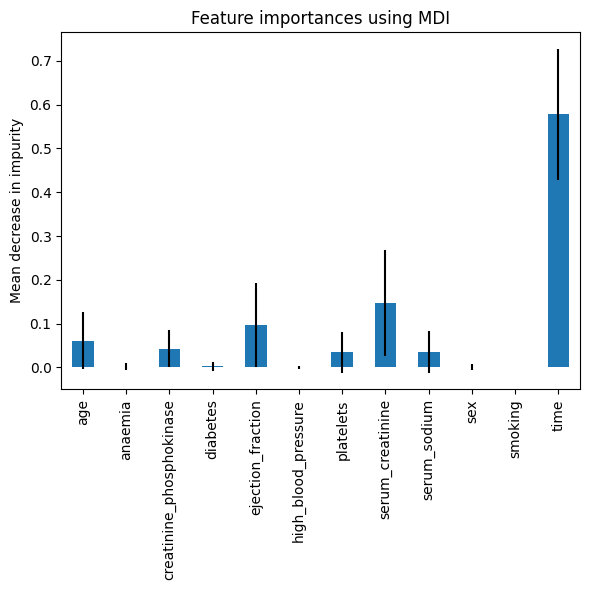

In [65]:
feature_names = rf.feature_names_in_
rf_importances = pd.Series(rf.feature_importances_, index=feature_names)
std = np.std([rf.feature_importances_ for rf in rf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(6,6))
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

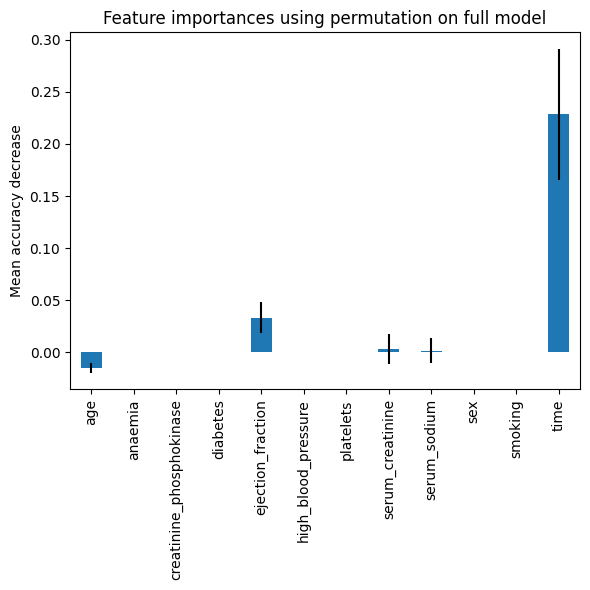

In [66]:
result = permutation_importance(rf, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
rf_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(6,6))
rf_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [67]:
y = data['DEATH_EVENT']
x = data.drop(['sex', 'smoking', 'high_blood_pressure', 'anaemia', 'diabetes', 'DEATH_EVENT'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [68]:
rf = RandomForestClassifier(max_depth=7,
 max_features=1,
 min_samples_split=20,
 n_estimators=152)
rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)
print(f'model accuracy: {accuracy_score(y_pred, y_test)*100}%')

model accuracy: 85.0%


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.94      0.65      0.77        23

    accuracy                           0.85        60
   macro avg       0.88      0.81      0.83        60
weighted avg       0.86      0.85      0.84        60



In [81]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)

y_pred_gb = gb.predict(x_test)

print(f'Gradient Boosting accuracy: {accuracy_score(y_pred_gb, y_test)*100}%')

Gradient Boosting accuracy: 86.66666666666667%


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.94      0.65      0.77        23

    accuracy                           0.85        60
   macro avg       0.88      0.81      0.83        60
weighted avg       0.86      0.85      0.84        60

